## Importing libraries

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import LSTM, Flatten

from google.colab import drive
drive.mount('/content/drive')

# To get reproducible results
from numpy.random import seed 
seed(0) 
tensorflow.random.set_seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [103]:
df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Lab dataset/reactor1_biogas.csv', index_col="day", usecols = ["day", "PH100", "TI100_PV", "reactor1"])
df.sort_index(inplace=True)
df.head()

,PH100,TI100_PV,reactor1
day,,,
0,8.074410,36.000625,0
1,8.096889,35.664028,100
2,7.870299,35.768889,120
3,7.774347,35.843681,100
4,7.733986,35.853194,100


## Plotting the different values
This section takes a look at the trend in the biogas values, VS and TS values.

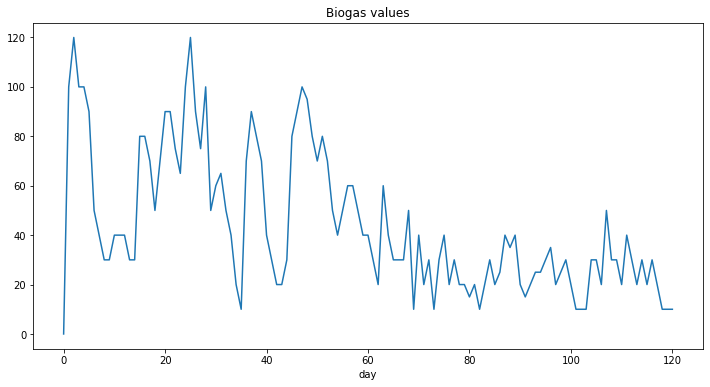

In [104]:
# Biogas values
df["reactor1"].plot(figsize=(12,6), title= "Biogas values")

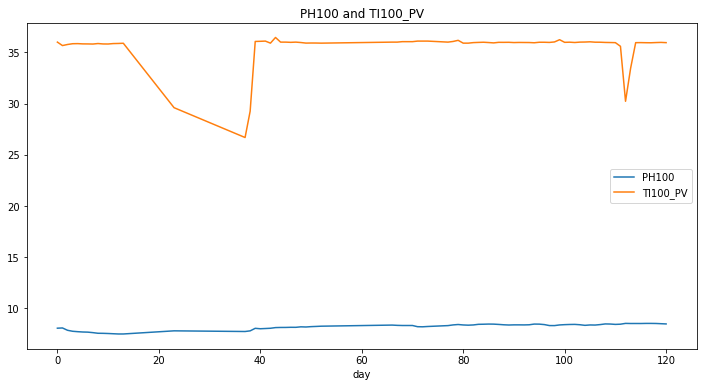

In [105]:
# VS and TS values
df[["PH100", "TI100_PV"]].plot(figsize=(12,6), legend=True, title = "PH100 and TI100_PV")

### Decomposing the plot
Using seasonal-decompose to find a trend, seasonal changes and noise in the plot.

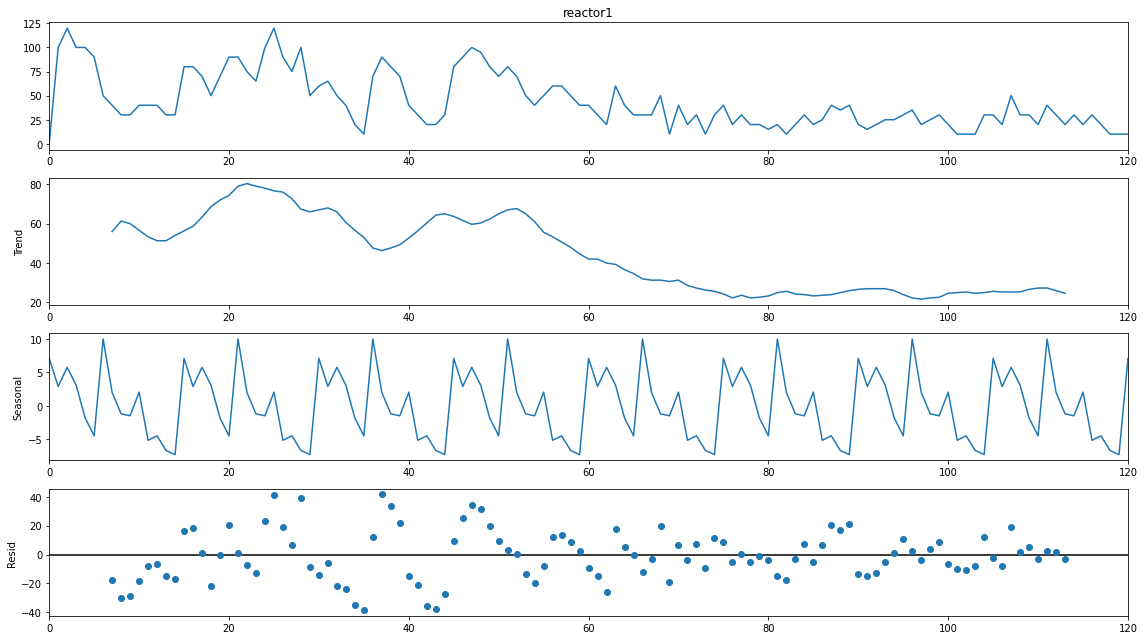

In [106]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(x= df['reactor1'],  period = 15, model='additive')
decompose_plot = results.plot();
decompose_plot.set_size_inches((16, 9))
# Tight layout to realign things
decompose_plot.tight_layout()
decompose_plot.show()

## Scaling the data
The train-test split needs to be done in a sequential manner, and not randomly.

In [107]:
# Using the MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(df)

scaled_dataset = scaler.transform(df)

## Generating sequences
To generate a series based input for our model.

In [108]:
def sequenceGenerator(dataset, sequenceSize=1):
  #Function that returns X and y from a given set of data points, where X is a set of sequences
    X = []
    y = []

    # using a sliding window to get values for the sequence. The value just after the sequnce is used as y
    for i in range(len(dataset)-sequenceSize-1):
        current_window = dataset[i:(i+sequenceSize), :]
        X.append(current_window)
        y.append(dataset[i+sequenceSize, -1])
        
    return np.array(X),np.array(y)

# Using the function to generate train and test sequences

# Defining the sequence size to be used.
sequence_size = 8
X, y = sequenceGenerator(scaled_dataset, sequence_size)
len(X)

112

## Splitting into train and test set
This needs to be done sequentially.

In [109]:
# Setting a fraction for train data
train_fraction = 0.7
train_size = (int)(len(X)*train_fraction)

# Splitting the train and test data
X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size :]
y_test = y[train_size :]

# Building LSTM models

## Input shape
LSTMs expect input array to be a 3D array: (batch_size, time_steps, seq_len)
* `batch_size` = Number of inputs in the training data
* `time_steps` = Number of historical datapoints being given
* `seq_len` = Number of features in a single historical datapoint

Example 1: If there are 2500 training sentences, with 50 words in each, with each word being encoded as an integer, then the input shape would be: `(2500, 50, 1)` 

So, for univariate analysis, the input shape will be:  
`(num_training_observations, sequence_size, 1)`

For multivariate analysis, the shape does not need to change.


## a) Single LSTM layer (64 neurons)

In [30]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 3s 269ms/step - loss: 0.8084 - val_loss: 0.3608
Epoch 2/100
3/3 [==============================] - 0s 20ms/step - loss: 0.7174 - val_loss: 0.2729
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6652 - val_loss: 0.2170
Epoch 4/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6342 - val_loss: 0.1766
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6063 - val_loss: 0.1585
Epoch 6/100
3/3 [==============================] - 0s 27ms/step - loss: 0.5876 - val_loss: 0.1444
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.5755 - val_loss: 0.1349
Epoch 8/100
3/3 [==============================] - 0s 19ms/step - loss: 0.5634 - val_loss: 0.1282
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 0.5516 - val_loss: 0.1238
Epoch 10/100
3/3 [==============================] - 0s 18ms/step - loss: 0.5406 - val_loss: 0.1214
Epoch 11/100
3/3 [

### Plotting the loss

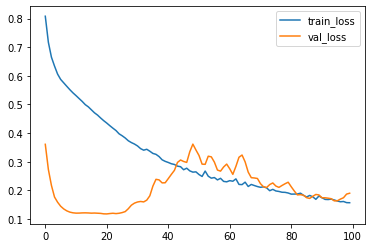

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 0s 5ms/step


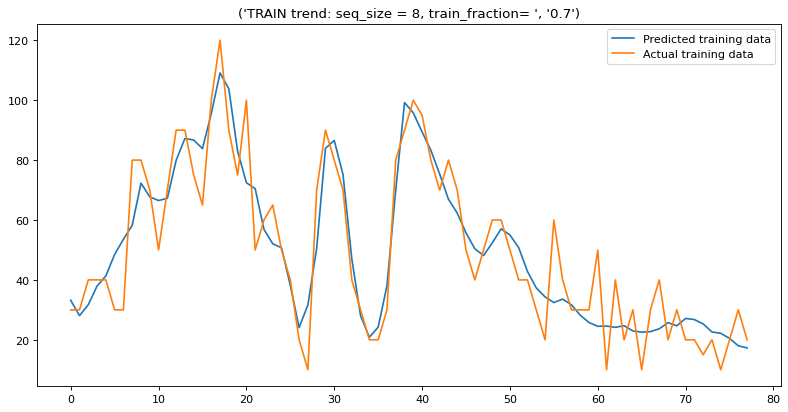

In [33]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 7ms/step


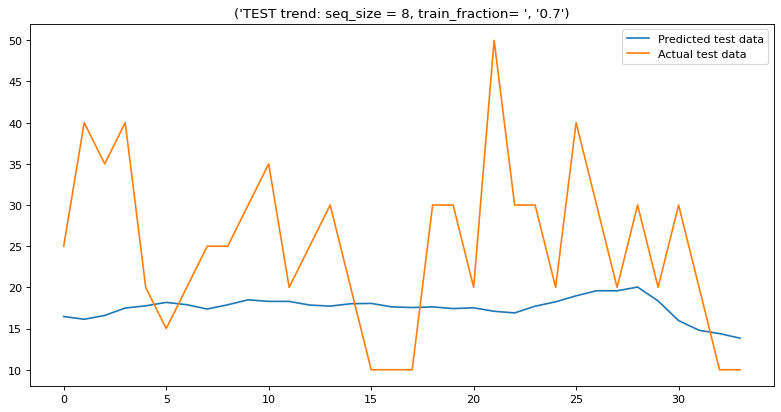

In [34]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

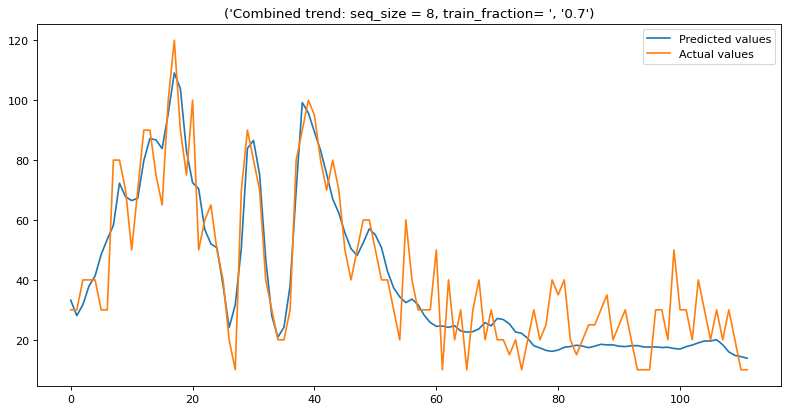

In [35]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [36]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.833 ,  -0.592 ,  0.804


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [37]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  11.004 ,  12.19 ,  11.377


### Analysis
**1. Sequence size of 8, train size of 0.7**  
1. Trend is followed on train data.
2. Test data: valeus are lower than mean, almost a straight line.
3. r2 score:  0.833 ,  -0.592 ,  0.804
4. RMSE:  11.004 ,  12.19 ,  11.377


## b) 1 LSTM + 1 Dense layer

In [62]:
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(20, activation="relu"))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20)                1920      
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,361
Trainable params: 2,361
Non-trainable params: 0
_________________________________________________________________


In [63]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 3s 258ms/step - loss: 1.3481 - val_loss: 0.6510
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 1.2491 - val_loss: 0.6098
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 1.1679 - val_loss: 0.5674
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 1.1070 - val_loss: 0.5231
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 1.0657 - val_loss: 0.4785
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 1.0268 - val_loss: 0.4356
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.9938 - val_loss: 0.3927
Epoch 8/100
3/3 [==============================] - 0s 17ms/step - loss: 0.9597 - val_loss: 0.3526
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9269 - val_loss: 0.3171
Epoch 10/100
3/3 [==============================] - 0s 17ms/step - loss: 0.9004 - val_loss: 0.2873
Epoch 11/100
3/3 [

### Plotting the loss

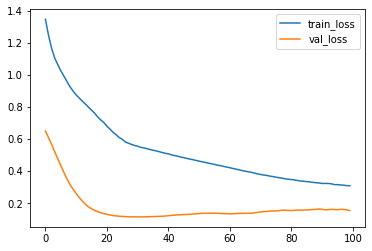

In [64]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 0s 4ms/step


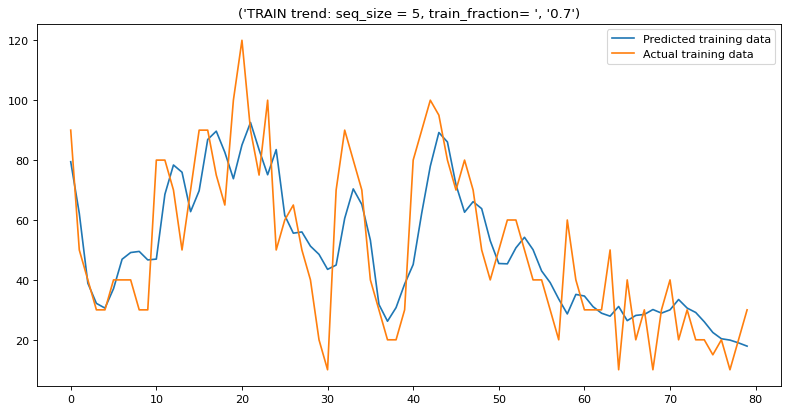

In [65]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 5ms/step


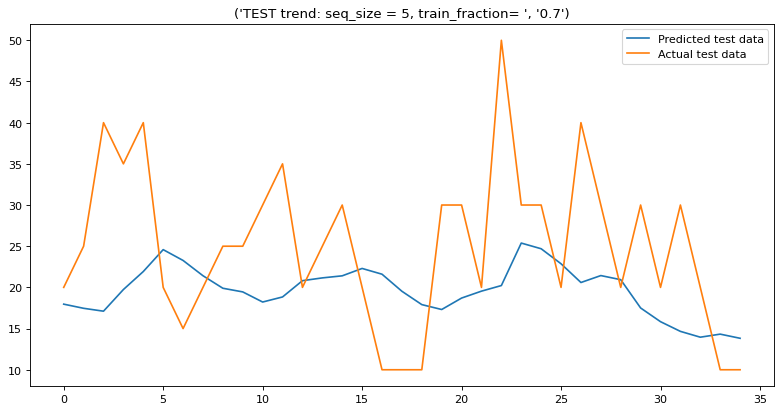

In [66]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

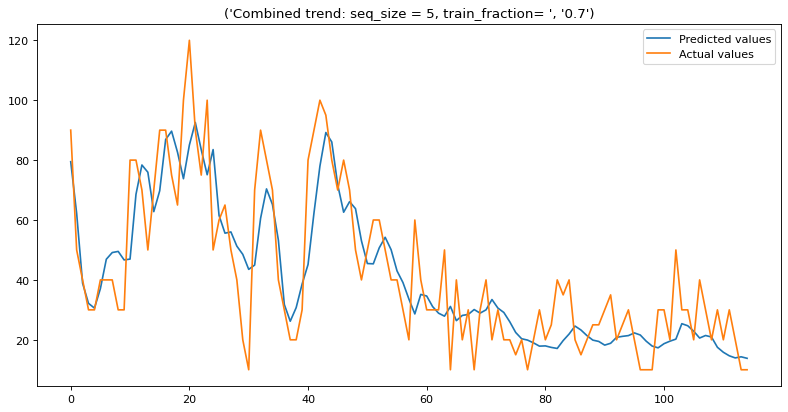

In [67]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [68]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.665 ,  -0.324 ,  0.692


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [69]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  15.504 ,  11.004 ,  14.285


### Analysis
**1. Sequence size of 5, train size of 0.7**
1. Train data: Lag is present.
2. Test data: Values are almost straight line, slightly lower than the mean.
3. r2 score:  0.665 ,  -0.324 ,  0.692
4. RMSE:  15.504 ,  11.004 ,  14.285



## c) 2 LSTM layers 


In [78]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 20)             1920      
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,221
Trainable params: 5,221
Non-trainable params: 0
_________________________________________________________________


In [79]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 6s 509ms/step - loss: 0.9984 - val_loss: 0.4644
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 0.9677 - val_loss: 0.4388
Epoch 3/100
3/3 [==============================] - 0s 21ms/step - loss: 0.9424 - val_loss: 0.4088
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 0.9210 - val_loss: 0.3769
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 0.9021 - val_loss: 0.3445
Epoch 6/100
3/3 [==============================] - 0s 28ms/step - loss: 0.8788 - val_loss: 0.3129
Epoch 7/100
3/3 [==============================] - 0s 19ms/step - loss: 0.8578 - val_loss: 0.2799
Epoch 8/100
3/3 [==============================] - 0s 19ms/step - loss: 0.8349 - val_loss: 0.2473
Epoch 9/100
3/3 [==============================] - 0s 21ms/step - loss: 0.8088 - val_loss: 0.2179
Epoch 10/100
3/3 [==============================] - 0s 20ms/step - loss: 0.7866 - val_loss: 0.1939
Epoch 11/100
3/3 [

### Plotting the loss

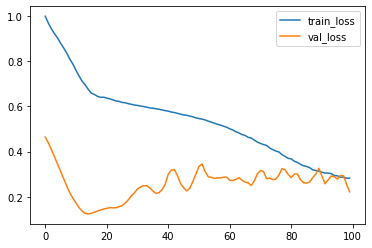

In [80]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 6ms/step


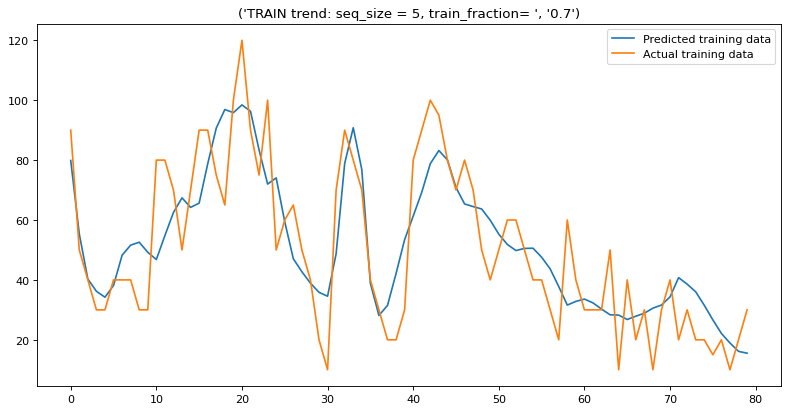

In [81]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 7ms/step


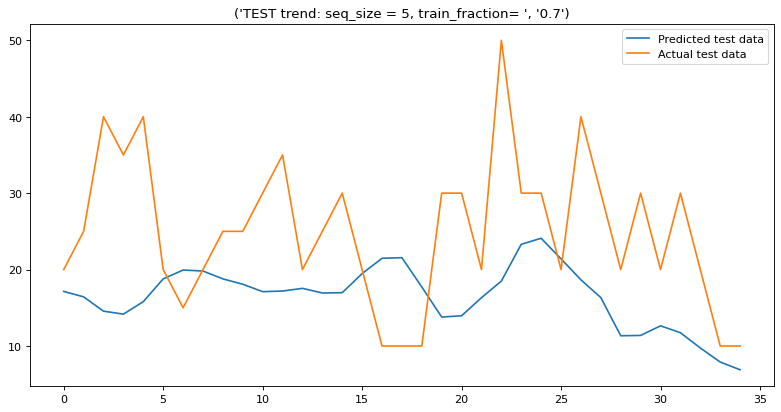

In [82]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

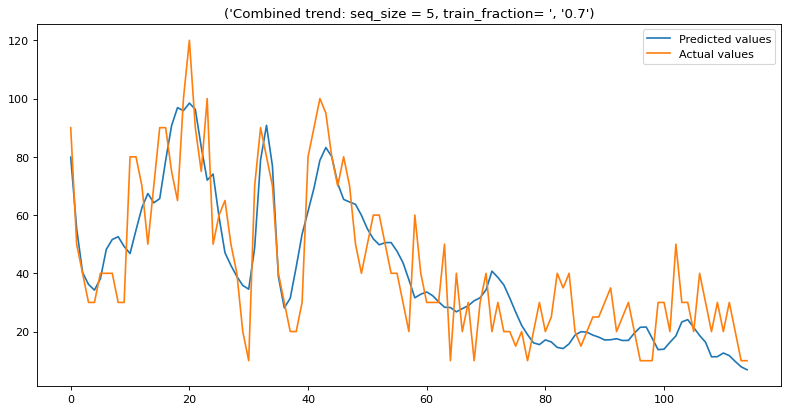

In [83]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [84]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.699 ,  -0.903 ,  0.694


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [85]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  14.692 ,  13.19 ,  14.251


### Analysis
**1. Sequence size of 5, train size of 0.7**
1. Generalised on the train data.
2. Test data: Close to mean, slightly lower. Trend is very very slightly followed.
3. r2 score:  0.699 ,  -0.903 ,  0.694
4. RMSE:  14.692 ,  13.19 ,  14.251





## d) 2 LSTM layers + 1 Dense layer


In [110]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 8, 20)             1920      
                                                                 
 lstm_9 (LSTM)               (None, 20)                3280      
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 5,641
Trainable params: 5,641
Non-trainable params: 0
_________________________________________________________________


In [111]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 5s 551ms/step - loss: 0.9639 - val_loss: 0.5898
Epoch 2/100
3/3 [==============================] - 0s 36ms/step - loss: 0.9402 - val_loss: 0.5514
Epoch 3/100
3/3 [==============================] - 0s 42ms/step - loss: 0.9208 - val_loss: 0.5148
Epoch 4/100
3/3 [==============================] - 0s 37ms/step - loss: 0.9045 - val_loss: 0.4796
Epoch 5/100
3/3 [==============================] - 0s 31ms/step - loss: 0.8836 - val_loss: 0.4484
Epoch 6/100
3/3 [==============================] - 0s 38ms/step - loss: 0.8651 - val_loss: 0.4163
Epoch 7/100
3/3 [==============================] - 0s 32ms/step - loss: 0.8452 - val_loss: 0.3843
Epoch 8/100
3/3 [==============================] - 0s 30ms/step - loss: 0.8212 - val_loss: 0.3499
Epoch 9/100
3/3 [==============================] - 0s 31ms/step - loss: 0.7962 - val_loss: 0.3097
Epoch 10/100
3/3 [==============================] - 0s 34ms/step - loss: 0.7669 - val_loss: 0.2670
Epoch 11/100
3/3 [

### Plotting the loss

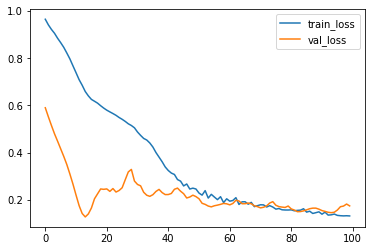

In [112]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 7ms/step


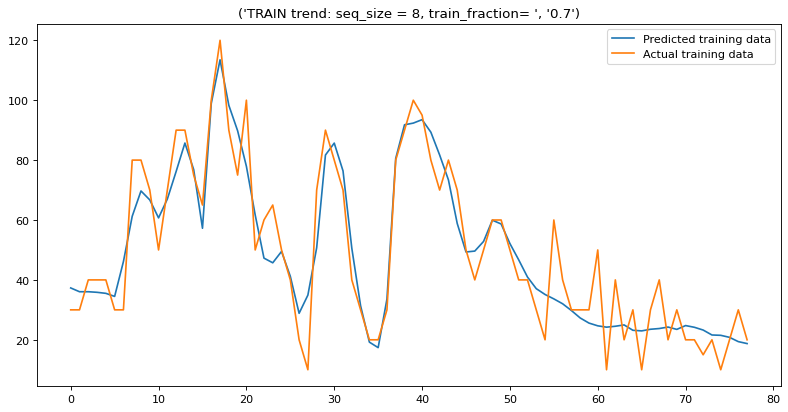

In [113]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 8ms/step


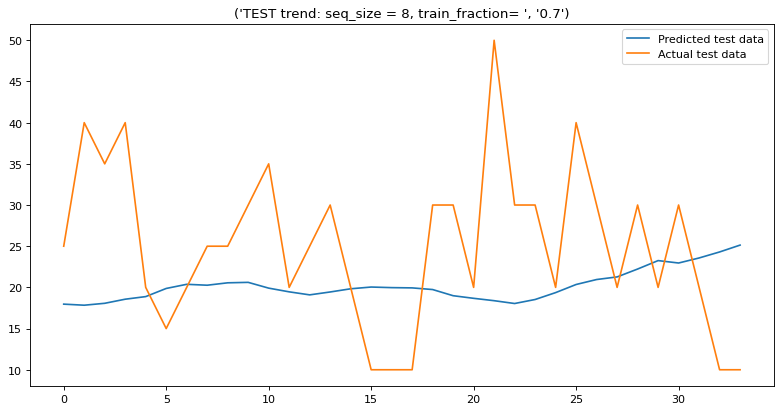

In [114]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

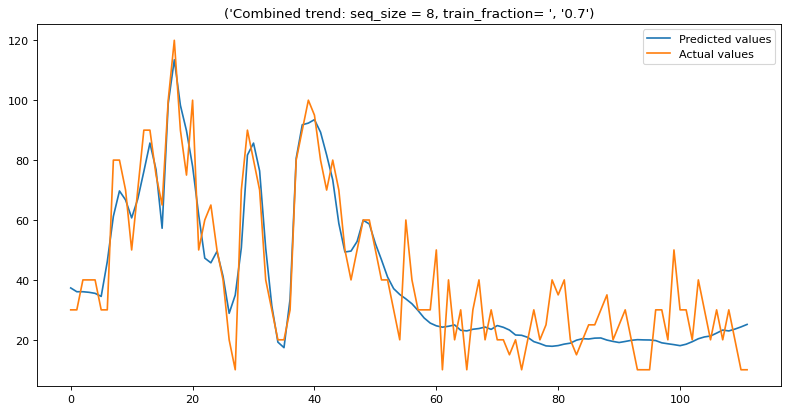

In [115]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [116]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.861 ,  -0.466 ,  0.831


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [117]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  10.029 ,  11.701 ,  10.565


### Analysis
**1. Sequence size of 8, train size of 0.7**
1. Values fit very well on the train data. 
2. Test data: Straight line lower than mean.
3. r2 score:  0.861 ,  -0.466 ,  0.831
4. RMSE:  10.029 ,  11.701 ,  10.565


